# Customer Segmentation Classification with multi-level categorical outputs

Customer Segmentation
The aim of this project is to classify new customers into known segmentations (A, B, C, D) for marketing purpose. There will be training data / historical records of classified customers, and new data / validation data from new customers. This will be a “Classification” model using python.

Data set Volume:
Train: 8068
Validation: 2627

Dimensions / Predictors:
ID	-   Unique ID   -	Integer
Gender  -	Gender of the customer  -	Categorical
Ever Married    -	Marital status of the customer  -	Binary (Yes/No)
Age -	Age of the customer -	Integer
Graduated   -	Is the customer a graduate? -	Binary (Yes/No)
Profession  -	Profession of the customer  -	Categorical
Work Experience -	Work Experience in years    -	Integer
Spending Score  -	Spending score of the customer  -	Categorical
Family Size -	Number of family members for the customer (including the customer)  -   Integer
Var_1   -   Anonymised Category for the customer

Output:
Segmentation    -   (target) Customer Segment of the customer   -   Categorical (A/B/C/D)

In [515]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

In [516]:
train = pd.read_csv('D:\Code\Python\SLC_Class\ADMN5016Ai\Train.csv')
test = pd.read_csv('D:\Code\Python\SLC_Class\ADMN5016Ai\Test.csv')
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [517]:
train.shape

(8068, 11)

In [518]:
test.shape

(2627, 11)

In [519]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


# Preprocessing / Cleaning Data

In [520]:
print(train.isnull().sum())

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64


In [521]:
# This filters out rows with 2 or more null values // keeps rows with (Dimension-2) or more non-null values.
train = train.dropna(thresh=train.shape[1]-2)
# drop ID column
train=train.drop('ID', 1)
print(train.isnull().sum())

Gender               0
Ever_Married       134
Age                  0
Graduated           72
Profession         113
Work_Experience    813
Spending_Score       0
Family_Size        320
Var_1               72
Segmentation         0
dtype: int64


C:\Users\SXH\AppData\Local\Temp\ipykernel_10756\190059481.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train=train.drop('ID', 1)


In [522]:
# obtainign the categroical columns
catcols = []
for i in train.columns:
  if train[i].dtype == "object":
      catcols.append(i)
catcols 

['Gender',
 'Ever_Married',
 'Graduated',
 'Profession',
 'Spending_Score',
 'Var_1',
 'Segmentation']

In [523]:
#Replacing the missing values in the categorical variables as "not_available"
train[catcols[:-1]] = train[catcols[:-1]].fillna("not_available")
print(train.isnull().sum())

Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession           0
Work_Experience    813
Spending_Score       0
Family_Size        320
Var_1                0
Segmentation         0
dtype: int64


Median value of Family size feature is: 1.0


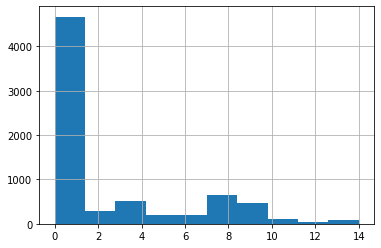

In [524]:
train['Work_Experience'].hist(bins = 10)
print("Median value of Family size feature is:",train['Work_Experience'].median())

Median value of Family size feature is: 3.0


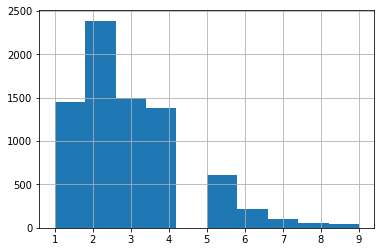

In [525]:
train['Family_Size'].hist(bins = 10)
print("Median value of Family size feature is:",train['Family_Size'].median())

In [526]:
train['Work_Experience']=train['Work_Experience'].fillna(train['Work_Experience'].median())
train['Family_Size']=train['Family_Size'].fillna(train['Family_Size'].median())
print(train.isnull().sum())

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64


In [527]:
train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A


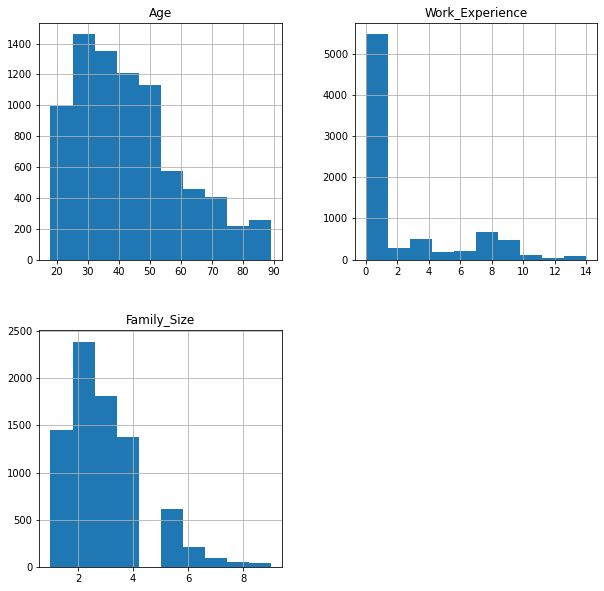

In [528]:
train.hist(bins=10, figsize=(10,10))
plt.show()

# Code the categorical Columns

In [529]:
# Set numerical references
gender_map = {'Male': 0,'Female': 1}
marriage_map = {'not_available': 9, 'No': 0, 'Yes': 1}
graduate_map = {'not_available': 9, 'No': 0, 'Yes': 1}
profession_map = {'Artist': 0,'Doctor': 1,'Engineer': 2,'Entertainment': 3,'Executive': 4,'Healthcare': 5,
                   'Homemaker': 6,'Lawyer': 7,'Marketing': 8,'not_available': 9}
spending_map = {'Average': 1, 'High': 2, 'Low': 0}
var_map = {'Cat_1': 1,'Cat_2': 2,'Cat_3': 3,'Cat_4': 4,'Cat_5': 5, 'Cat_6': 6, 'Cat_7': 7,'not_available': 9}
target_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

In [530]:
# Map the references
le = LabelEncoder()
train["Gender"] =  train["Gender"].map(gender_map)
train["Ever_Married"] =  train["Ever_Married"].map(marriage_map)
train["Graduated"] =  train["Graduated"].map(graduate_map)
train["Profession"] =  train["Profession"].map(profession_map)
train["Spending_Score"] =  train["Spending_Score"].map(spending_map)
train["Var_1"] =  train["Var_1"].map(var_map)
train["Segmentation"] =  train["Segmentation"].map(target_map)

In [531]:
train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,0,0,22,0,5,1.0,0,4.0,4,3
1,1,1,38,1,2,1.0,1,3.0,4,0
2,1,1,67,1,2,1.0,0,1.0,6,1
3,0,1,67,1,7,0.0,2,2.0,6,1
4,1,1,40,1,3,1.0,2,6.0,6,0


# Preprocessing Test data

In [532]:
test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


In [533]:
print(test.isnull().sum())

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
Segmentation         0
dtype: int64


In [534]:
test = test.dropna(thresh=train.shape[1]-2)
#drop ID column
test=test.drop('ID', 1)
print(test.isnull().sum())

Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
Segmentation         0
dtype: int64


C:\Users\SXH\AppData\Local\Temp\ipykernel_10756\2690682041.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test=test.drop('ID', 1)


In [535]:
#obtainign the categroical columns alone
catcolsTest = []
for i in test.columns:
  if test[i].dtype == "object":
      catcolsTest.append(i)
catcolsTest 

['Gender',
 'Ever_Married',
 'Graduated',
 'Profession',
 'Spending_Score',
 'Var_1',
 'Segmentation']

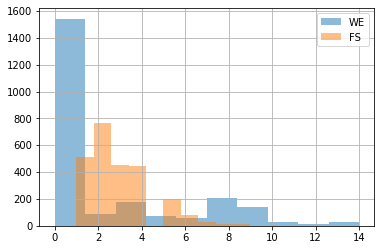

In [536]:
#Replacing the missing values in the categorical variables as "not_available"
test[catcolsTest[:-1]] = test[catcolsTest[:-1]].fillna("not_available")
#Replace missing numerical value with median
test['Work_Experience'].hist(alpha = 0.5, label = 'WE')
test['Family_Size'].hist(alpha = 0.5, label = 'FS')
plt.legend(loc='upper right')

In [537]:
test['Work_Experience']=test['Work_Experience'].fillna(test['Work_Experience'].median())
test['Family_Size']=test['Family_Size'].fillna(test['Family_Size'].median())
print(test.isnull().sum())

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64


In [538]:
test["Gender"] =  test["Gender"].map(gender_map)
test["Ever_Married"] =  test["Ever_Married"].map(marriage_map)
test["Graduated"] =  test["Graduated"].map(graduate_map)
test["Profession"] =  test["Profession"].map(profession_map)
test["Spending_Score"] =  test["Spending_Score"].map(spending_map)
test["Var_1"] =  test["Var_1"].map(var_map)
test["Segmentation"] =  test["Segmentation"].map(target_map)
test.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1,1,36,1,2,0.0,0,1.0,6,1
1,0,1,37,1,5,8.0,1,4.0,6,0
2,1,1,69,0,9,0.0,0,1.0,6,0
3,0,1,59,0,4,11.0,2,2.0,6,1
4,1,0,19,0,8,1.0,0,4.0,6,0


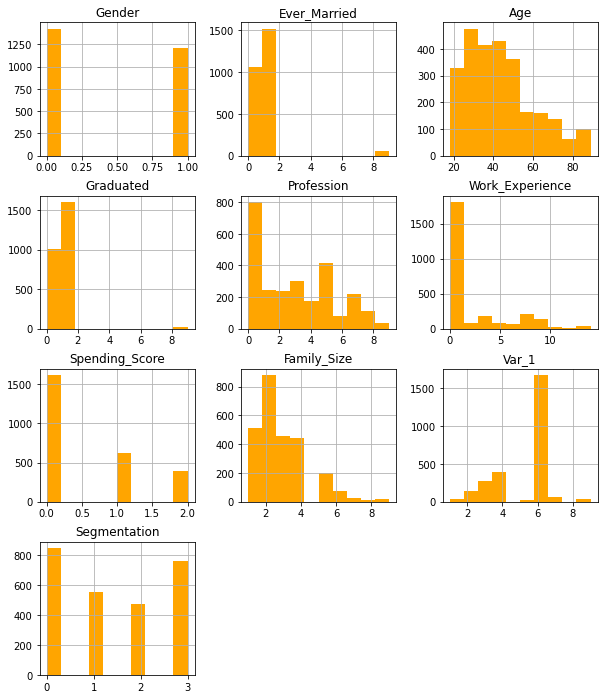

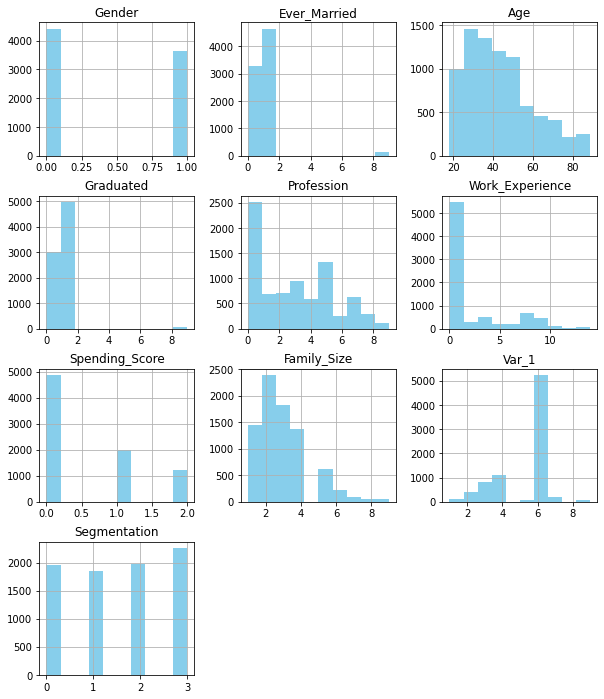

In [539]:
test.hist(bins=10, figsize=(10,12), color = 'orange')
train.hist(bins=10, figsize=(10,12), color = 'skyblue')
plt.show()

# Model - Random Forest

In [540]:
X_train = train.iloc[0:len(train),0:9:]
y_train = train['Segmentation']
X_test=test.iloc[0:len(test),0:9:]
y_test=test['Segmentation']

In [541]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8049 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8049 non-null   int64  
 1   Ever_Married     8049 non-null   int64  
 2   Age              8049 non-null   int64  
 3   Graduated        8049 non-null   int64  
 4   Profession       8049 non-null   int64  
 5   Work_Experience  8049 non-null   float64
 6   Spending_Score   8049 non-null   int64  
 7   Family_Size      8049 non-null   float64
 8   Var_1            8049 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 628.8 KB


In [542]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 8049 entries, 0 to 8067
Series name: Segmentation
Non-Null Count  Dtype
--------------  -----
8049 non-null   int64
dtypes: int64(1)
memory usage: 125.8 KB


In [543]:
M_features=train.shape[1]
max_features=round(np.sqrt(M_features))-1
max_features

2

In [544]:
n_estimators = 20

In [545]:
model = RandomForestClassifier( max_features=max_features,n_estimators=n_estimators, random_state=0)
model.fit(X_train,y_train)

RandomForestClassifier(max_features=2, n_estimators=20, random_state=0)

In [546]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

In [547]:
print(get_accuracy(X_train, X_test, y_train, y_test, model)) 

{'test Accuracy': 0.31328511610201754, 'train Accuracy': 0.9468256926326252}


# K Nearest Neighbours

In [548]:
import time
from sklearn.neighbors import KNeighborsClassifier
import itertools

# For loop to find the K with the best accuracy

In [596]:
accP = 0
bestk = 1
for k in range(1,100):
    KNN= KNeighborsClassifier(n_neighbors=k,algorithm = 'kd_tree')
    KNN.fit(X_train,y_train)
    yhat=KNN.predict(X_test)
    acc = np.mean(yhat==y_test)

    if acc > accP:
        accP = acc
        bestK = k

print("the best K value is:",bestK,", ","the best accuracy for the validation data is:", accP)
    

the best K value is: 77 ,  the best accuracy for the validation data is: 0.34221545489151123


In [597]:
k = 77
KNN= KNeighborsClassifier(n_neighbors=k,algorithm = 'kd_tree')
KNN

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=77)

In [598]:
startTime = time.time()

# this is where we train the model 
KNN.fit(X_train,y_train)

lapsedTime = time.time() - startTime
print('time:',lapsedTime,' sec' )

time: 0.042905569076538086  sec


In [599]:
startTime = time.time()

# this is where we make the prediction  
yhat=KNN.predict(X_test)
yThat=KNN.predict(X_train)

lapsedTime = time.time() - startTime
print('time:',lapsedTime,' sec' )
yhat[0:10]

time: 1.2419991493225098  sec


array([0, 0, 1, 2, 3, 2, 2, 2, 2, 3], dtype=int64)

In [600]:
# Accuracy
print("KNN validation accuracy is", np.mean(yhat==y_test))
print("KNN train accuracy is", np.mean(yThat==y_train))

KNN validation accuracy is 0.34221545489151123
KNN train accuracy is 0.5004348366256678


# Confusion Matrix

In [601]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = 3*cm.max()/4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [602]:
target_names = ['0','1','2','3']
print("confusion matrix:")
print( confusion_matrix(yhat,y_test))

confusion matrix:
[[242 140 125 167]
 [118  93  69  71]
 [223 194 201 158]
 [263 123  77 363]]


Confusion matrix, without normalization
[[242 140 125 167]
 [118  93  69  71]
 [223 194 201 158]
 [263 123  77 363]]


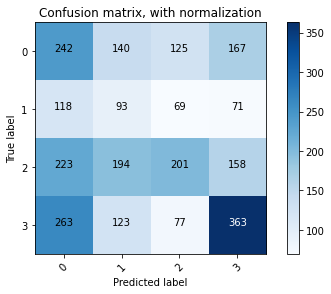

In [603]:
plot_confusion_matrix(confusion_matrix(yhat,y_test), classes=target_names,title='Confusion matrix, with normalization')

In [604]:
from sklearn.metrics import precision_recall_fscore_support,recall_score,accuracy_score
prf1=precision_recall_fscore_support(y_test,yhat)
acc=accuracy_score(y_test,yhat)

def pretty_metrics(precision_recall_fscore=0,accuracy_score=0):
    if precision_recall_fscore==0:
        metric_dict={'accuracy':[],'precision':[],'recall':[],'F1':[]}
        return metric_dict
    #This function prints out the precision, recall,f-score and accuracy is also saves the result to a dictionary 
    metric_dict={'accuracy':[],'precision':[],'recall':[],'F1':[]}
    metric_dict['accuracy']=accuracy_score
    metric_dict['precision']=precision_recall_fscore[0][1]
    metric_dict['recall']=precision_recall_fscore[1][1]
    metric_dict['F1']=precision_recall_fscore[2][1]
    [print(key,value) for key, value in metric_dict.items()]
    return metric_dict

metric=pretty_metrics(precision_recall_fscore=prf1,accuracy_score=acc)

accuracy 0.34221545489151123
precision 0.26495726495726496
recall 0.1690909090909091
F1 0.2064372918978912


# Grid Search

In [613]:
from sklearn.model_selection import GridSearchCV
param_grid={'n_neighbors':[1,2],'algorithm':[ 'kd_tree']}
grid = GridSearchCV(KNeighborsClassifier(), cv=2, param_grid=param_grid,scoring="accuracy",n_jobs=-1)
print("Done")

Done


In [614]:
startTime=time.time()
# this is where we fit the model 
grid.fit(X_test,y_test)
lapsedTime = time.time() - startTime
print('time:',lapsedTime,' sec' )

time: 0.2070000171661377  sec


In [615]:
grid.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 2}

In [616]:
grid.best_score_

0.3026296570647581